# AFRICAN INSTITUTE FOR MATHEMATICAL SCIENCES

## NAME: AUBREY UNDI PHIRI
## COUSRE: DIG DATA ANALYSIS WITH PYTHON
## TASK: Mobility-Big-Data-Analysis-and-processing-with-Apache-Spark-projects 
### DATE: 2024/1/20


---


---

## Project Scoping



## * THE PROJECT USED ALL THE CSV FILES IN THE ZIPPED FILE simulated_cdrs.zip.

  THE FILE WAS THEN EXTRACTED TO A FOLDER WHICH WAS THEN USED TO CREATE ONE BIG CSV FILE AND ALL THE USERS WERE USED FOR ANALYSIS OF THE DATA TO IMPROVE ACCURACY, THE NUMBER OF USERS HOWEVER DROPPED SIGNIFICANTLY AFTER CLEANING THE DATA.



##  * THE DATA WAS CLEANED IN TWO STAGES FOR QUALITY IMPROVEMENTS.


##  * THE CLEANDED DATAFRAME WAS READY FOR ANALYSIS.

---
---

#  Python setup
Import all the required Python packages.

In [ ]:
#if not installed uncomment below and install
#! pip install pyspark
#! pip install pandas

REQUIRED LIBRARIES

In [ ]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, udf, avg, count, countDistinct, to_date, expr, sqrt, pow, collect_list, corr
from pyspark.sql.types import TimestampType, DateType
import pandas as pd
import random
import os
from pathlib import Path
from geopy.distance import geodesic

# Setup working directories
Its also important to setup commonly used diretories such as where you will be saving data

In [ ]:
# Setup global parameters and variables
MISC_PROCESSING_PARAMS = {'distance_threshold': 2, 'min_unique_locs': 2,'datetime_col': 'datetime',
                        'userid': 'user_id','x': 'lon', 'y': 'lat'}

# Data preprocessing.
Often, after all the data has been  acquired, thee next step is to do some preprocessing on the raw data.
The objectives of this task will vary depending on the data analysis goals but some of them include following:
- **Sanitize the data:** this data cleaning has to be done carefully to avoid introducing errors but its often a necessary step. It can involve dropping some unnecessary variables/columns. Renaming some columns to something which makes more sense. Dropping some observations. For instance, in this analysis where location and time-stamp is important, dropping all observations with no time-stamp and no location is required.
- **Create new variables:**. If necessary, this is also the time transform some variables from a format which is not convinient for your analysis. For instance, converting string time variables to datetime aware variables.
- **Combine datasets:** If you have more than one dataset, during preprocessing, you can also combine several datasets into one. For instance, we have the CDR transations which have no location details. We bring in the location details from another file.
- **Filtering based on columns and observations:** This can be done through any of the stages mentioned above but its worth mentioning that often, you may drop some columns which arent useful for your analysis. Also, you may drop some observations based on some conditions depending on your analysis needs.

Unlike in other data collection domains such as surveys where you can have standard data processing steps, in the data science space where your dataset can be anything, there are no hard and fast rule for preprocessing and data cleaning. It will be a case by case basis depending on your analysis goals. Also, preprocessing isnt necessarily a linear process: depending on what results you get downstream, you can go back and modify the preprocesisng steps. In this project, we have the ```preprocess_cdrs_using_spark``` which takes raw cdrs and saves to a CSV a processed dataset. Alternatively, we can return a Spark DataFrame.



### checking the type of data set that is obtained:

It is important to check if all the dataset have the same format, especially in a situation where data is available on a public domain.

In [ ]:

# Import necessary library
from pathlib import Path

# Define base data directory
BASE_DIR = Path("/content/drive/MyDrive/raw/simulated_cdrs_extracted")

# Define paths to specific files and directories using joinpath()
loc_file = BASE_DIR.joinpath("simulated_locs.csv")
cdrs_dir = BASE_DIR.joinpath("simulated_cdrs")

# Verify the directory exists
print(f"Does base directory exist? {BASE_DIR.exists()}")

# Verify the files/directories exist
print(f"Location file exists? {loc_file.exists()}")
print(f"CDRs directory exists? {cdrs_dir.exists()}")

# To check the contents of the CDRs directory
if cdrs_dir.exists() and cdrs_dir.is_dir():
    print("\nFiles in CDRs directory:")
    for file in cdrs_dir.glob('*'):
        print(f"- {file.name}")


Streaming output truncated to the last 5000 lines.
- HW2018070821250010.dat.csv
- HW2018070808389243.dat.csv
- HW2018070617066871.dat.csv
- HW2018070311182203.dat.csv
- HW2018070913480993.dat.csv
- HW2018070623347259.dat.csv
- HW2018070902530339.dat.csv
- HW2018070609366421.dat.csv
- HW2018071219055630.dat.csv
- HW2018070411293654.dat.csv
- HW2018070310432168.dat.csv
- HW2018070523155800.dat.csv
- HW2018070518185503.dat.csv
- HW2018070405313296.dat.csv
- HW2018071007482073.dat.csv
- HW2018070421504275.dat.csv
- HW2018070102298794.dat.csv
- HW2018071109583643.dat.csv
- HW2018071307126357.dat.csv
- HW2018070703357500.dat.csv
- HW2018070218241189.dat.csv
- HW2018071108033528.dat.csv
- HW2018062917226807.dat.csv
- HW2018070218391204.dat.csv
- HW2018071305566281.dat.csv
- HW2018070316382523.dat.csv
- HW2018070617236888.dat.csv
- HW2018070919051310.dat.csv
- HW2018070500284433.dat.csv
- HW2018070707587763.dat.csv
- HW2018071113403865.dat.csv
- HW2018070811139398.dat.csv
- HW2018071110503695.

# PYSPARK SESSION

 THis part creates a spark session, and sefines the preprocessing function, where it takes raw CDR data, clean it partially by adding location information (longitude and latitude), renames the columns accordingly and return a structured DataFrame ready for further further processing.

In [ ]:


def preprocess_cdrs_using_spark(file_or_folder=None, number_of_users_to_sample=None,
                                output_csv=None, date_format='%Y%m%d%H%M%S',
                                debug_mode=True, loc_file=None, save_to_csv=False):
    """
    Perform basic preprocessing of Call Detail Records (CDRs) with file validation:
    1. Skip non-CSV files in the input folder.
    2. Rename columns to camelCase format.
    3. Change data types for specific columns.
    4. Add location details by merging with a location file.
    5. Optionally sample a subset of users for analysis.
    """
    if file_or_folder is None or loc_file is None:
        raise ValueError("Both 'file_or_folder' and 'loc_file' must be provided.")

    if number_of_users_to_sample is not None and number_of_users_to_sample <= 0:
        raise ValueError("'number_of_users_to_sample' must be greater than zero.")

    # Create a SparkSession
    spark = SparkSession.builder \
        .appName("CDR_Preprocessing") \
        .getOrCreate()

    # Check if file_or_folder is a folder or a single file
    if os.path.isdir(file_or_folder):
        # List only CSV files in the directory
        csv_files = [os.path.join(file_or_folder, f) for f in os.listdir(file_or_folder) if f.endswith('.csv')]
        if not csv_files:
            raise FileNotFoundError(f"No CSV files found in the directory: {file_or_folder}")
    else:
        # Single file provided; ensure it's a CSV
        if not file_or_folder.endswith('.csv'):
            raise ValueError(f"The specified file is not a CSV: {file_or_folder}")
        csv_files = [file_or_folder]

    # Read the CSV files into a Spark DataFrame
    df = spark.read.csv(csv_files, header=True, inferSchema=True)

    # Optimize performance by repartitioning
    df = df.repartition(10)

    # Debug mode: Process a smaller sample of the data
    if debug_mode:
        df = df.sample(fraction=0.1, seed=42)

    # Rename columns to camelCase format
    df = df.withColumnRenamed("cdr datetime", "cdrDatetime") \
           .withColumnRenamed("last calling cellid", "cellId") \
           .withColumnRenamed("call duration", "callDuration")

    # Drop unnecessary columns
    df = df.drop("cdr type")

    # Add timestamp and date columns using Spark UDFs
    add_datetime = udf(lambda x: pd.to_datetime(x, format=date_format), TimestampType())
    add_date = udf(lambda x: pd.to_datetime(x, format=date_format).date(), DateType())

    df = df.withColumn("timestamp", add_datetime(col("cdrDatetime"))) \
           .withColumn("date", add_date(col("cdrDatetime")))

    # Remove rows with null user IDs
    df = df.filter(col("user_id").isNotNull())

    # Load location data from the CSV file
    loc_df = pd.read_csv(loc_file)
    loc_df = loc_df.rename(columns={'cell_id': 'cellId'})
    sdf_loc = spark.createDataFrame(loc_df)

    # Join CDR data with location details
    df = df.join(sdf_loc, ["cellId"], "left")

    # Sample data for a subset of users
    if number_of_users_to_sample is not None:
        unique_users = [row.user_id for row in df.select("user_id").distinct().collect()]
        sampled_users = random.sample(unique_users, min(number_of_users_to_sample, len(unique_users)))
        df = df.filter(col("user_id").isin(sampled_users))

    # Save the processed data to a CSV if required
    if save_to_csv:
        if output_csv is None:
            raise ValueError("Output path 'output_csv' must be specified when 'save_to_csv' is True.")
        df.write.csv(output_csv, header=True, mode="overwrite")
        return None

    return df


### The implementing the processing function and caching the data.

The $preprocess\_cdrs\_using\_spark$ function is called to perform the main data preprocessing and combinin the csv files. (reading, cleaning, transforming). It takes the data paths, parameters, and formatting information as arguments.


The function is also Caching the processed data in memory for efficiency.  It caches the resulting DataFrame (dfu) in memory using .cache() to improve the efficiency of further operations.

In [ ]:

# Define base data directory
BASE_DIR = Path("/content/drive/MyDrive/raw/simulated_cdrs_extracted")

# Define paths
loc_file = BASE_DIR.joinpath("simulated_locs.csv")
cdrs_dir = BASE_DIR.joinpath("simulated_cdrs")

# Validate the location file and CDRs directory
if not loc_file.exists():
    raise FileNotFoundError(f"Location file not found: {loc_file}")
if not cdrs_dir.exists():
    raise FileNotFoundError(f"CDRs directory not found: {cdrs_dir}")

# List and validate CSV files in the CDRs directory
csv_files = [f for f in cdrs_dir.glob("*.csv")]
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in the directory: {cdrs_dir}")
print(f"Detected CSV files for processing: {[str(f) for f in csv_files]}")

# Preprocessing parameters
num_users = None  # Number of users to sample
debug = True  # Enable debug mode for faster testing
datetime_fmt = "%Y%m%d%H%M%S"

# Process the CDRs
dfu: DataFrame = preprocess_cdrs_using_spark(
    file_or_folder=str(cdrs_dir),
    number_of_users_to_sample=num_users,
    loc_file=str(loc_file),
    date_format=datetime_fmt,
    debug_mode=debug
).cache()

print("Preprocessing complete. Cached DataFrame is ready for use.")

Detected CSV files for processing: ['/content/drive/MyDrive/raw/simulated_cdrs_extracted/simulated_cdrs/HW2018062920296994.dat.csv', '/content/drive/MyDrive/raw/simulated_cdrs_extracted/simulated_cdrs/HW2018071311226607.dat.csv', '/content/drive/MyDrive/raw/simulated_cdrs_extracted/simulated_cdrs/HW2018071015422547.dat.csv', '/content/drive/MyDrive/raw/simulated_cdrs_extracted/simulated_cdrs/HW2018070700017286.dat.csv', '/content/drive/MyDrive/raw/simulated_cdrs_extracted/simulated_cdrs/HW2018070701527397.dat.csv', '/content/drive/MyDrive/raw/simulated_cdrs_extracted/simulated_cdrs/HW2018071014112456.dat.csv', '/content/drive/MyDrive/raw/simulated_cdrs_extracted/simulated_cdrs/HW2018070422154300.dat.csv', '/content/drive/MyDrive/raw/simulated_cdrs_extracted/simulated_cdrs/HW2018070316332518.dat.csv', '/content/drive/MyDrive/raw/simulated_cdrs_extracted/simulated_cdrs/HW2018070115129557.dat.csv', '/content/drive/MyDrive/raw/simulated_cdrs_extracted/simulated_cdrs/HW2018070809239288.dat.

### To have a visual structure of the data ensuring that in the next cleanong phase all the parameters needed to be cleaned are handled effectively.

In [ ]:
#Show the schema and first few rows
print("DataFrame Schema:")
dfu.printSchema()
print("\nFirst 5 rows of data:")
dfu.show(5)



DataFrame Schema:
root
 |-- cellId: double (nullable = true)
 |-- cdrDatetime: long (nullable = true)
 |-- callDuration: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- site_id: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)


First 5 rows of data:
+-------+--------------+------------+-------------------+-------------------+----------+-------+------------------+---------+
| cellId|   cdrDatetime|callDuration|            user_id|          timestamp|      date|site_id|               lat|      lon|
+-------+--------------+------------+-------------------+-------------------+----------+-------+------------------+---------+
|10338.0|20180710200731|        NULL|1813792474092406672|2018-07-10 20:07:31|2018-07-10|   S252|         -8.679244|26.938105|
|20593.0|20180702200117|        NULL| 456430917916573044|2018-07-02 20:01:17|2018-07-02|   NULL|      

### To improve accuracy of the data, the second cleaning phase futher cleans the data by first removing the null columns, then afterwards, further deals with the rows with zeros entirely, and any rows with null entry.

This function takes the DataFrame from above, removes incomplete or unnecessary data, adds a combined location column, and then stores the cleaned data for further analysis. This cleaning step is crucial for ensuring data quality and accurate results.

In [ ]:


def clean_dataframe(df: DataFrame) -> DataFrame:
    """
    Clean a Spark DataFrame by:
    - Removing columns with 100% null values
    - Removing rows with any null values
    - Removing rows with zero values in numeric columns
    - Adding a 'location' column derived from 'longitude' and 'latitude'

    Parameters:
    df (DataFrame): Input Spark DataFrame

    Returns:
    DataFrame: Cleaned Spark DataFrame
    """
    # Check if latitude and longitude are available to create a 'location' column
    if 'lat' in df.columns and 'lon' in df.columns:
        df = df.withColumn('location', concat_ws(",", col('lat'), col('lon')))
        print("Location column added from 'latitude' and 'longitude'.")

    # Get initial row and column count
    initial_row_count = df.count()
    initial_col_count = len(df.columns)
    print(f"Initial row count: {initial_row_count}, Initial column count: {initial_col_count}")

    # Remove columns with 100% null values
    non_null_columns = [
        c for c in df.columns if df.filter(col(c).isNotNull()).count() > 0
    ]
    df_no_nill_columns = df.select(non_null_columns)
    nill_columns_removed = set(df.columns) - set(non_null_columns)
    print(f"Columns removed due to being completely null: {nill_columns_removed}")
    print(f"Remaining columns after removing completely null columns: {len(df_no_nill_columns.columns)}")

    # Remove rows with any null values
    df_no_nulls = df_no_nill_columns.dropna()
    rows_after_null_removal = df_no_nulls.count()
    print(f"Rows remaining after removing rows with null values: {rows_after_null_removal}")

    #Remove rows where numeric columns are zero
    numeric_columns = [
        field.name for field in df_no_nulls.schema.fields
        if field.dataType.typeName() in ('integer', 'long', 'double', 'float')
    ]

    condition = None
    for col_name in numeric_columns:
        if condition is None:
            condition = (col(col_name) != 0)
        else:
            condition = condition & (col(col_name) != 0)

    if condition is not None:
        df_no_zeros = df_no_nulls.filter(condition)
    else:
        df_no_zeros = df_no_nulls

    rows_after_zero_removal = df_no_zeros.count()
    print(f"Rows remaining after removing rows with zeros in numeric columns: {rows_after_zero_removal}")

    # Final row and column count
    final_row_count = df_no_zeros.count()
    final_col_count = len(df_no_zeros.columns)
    print(f"Final row count: {final_row_count}, Final column count: {final_col_count}")

    return df_no_zeros

# Use the function on cached DataFrame
cleaned_dfu = clean_dataframe(dfu)

# Cache the cleaned DataFrame for faster access
cleaned_dfu = cleaned_dfu.cache()

# Show the cleaned data with the location column
cleaned_dfu.show()


Location column added from 'latitude' and 'longitude'.
Initial row count: 9524390, Initial column count: 10
Columns removed due to being completely null: {'callDuration'}
Remaining columns after removing completely null columns: 9
Rows remaining after removing rows with null values: 1416300
Rows remaining after removing rows with zeros in numeric columns: 1416300
Final row count: 1416300, Final column count: 9
+-------+--------------+-------------------+-------------------+----------+-------+------------------+---------+--------------------+
| cellId|   cdrDatetime|            user_id|          timestamp|      date|site_id|               lat|      lon|            location|
+-------+--------------+-------------------+-------------------+----------+-------+------------------+---------+--------------------+
|10338.0|20180710200731|1813792474092406672|2018-07-10 20:07:31|2018-07-10|   S252|         -8.679244|26.938105| -8.679244,26.938105|
|34249.0|20180711204536|5572531449161279759|2018-0

# TASK 2



# Explolatory Data Analysis (EDA)
Whether the end result of your project is to produce a statistical report or
to build a prediction model to be put in production, EDA is an essential stage in any data science project. EDA can be defined as
the process of performing initial investigations on data so as to discover patterns,to spot anomalies,
to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.
It is a good practice to understand the data first and try to gather as many insights from it.
EDA is all about making sense of data before using the data for the intended use (e.g., build ML models, perfom statisitcal analysis).

Again, there arent hard and fast rules on how to perfom EDA but some of the specific quesitons you would like to answer are as folloes:
- For each variable in the data, whats its distribution? Is it skewed? Whats its data type? Is it an approapriate  data type fopr my analysis. Are there any outliers?
- Whats the relationship between variables?

In this project, we will use the ```explore_data``` and explore what functions Spark has for basic EDA.


## Total number of days

In [ ]:


def calculate_total_days(df):
    # Ensure the DataFrame has a date column
    if 'date' not in df.columns:
        print("Error: The DataFrame does not contain a 'date' column.")
        return

    # Extract unique dates and count them
    total_days = df.select(to_date(col('date')).alias('only_date')).distinct().count()
    print(f"Total number of days in the dataset: {total_days}")

# Call the function on the cleaned DataFrame
calculate_total_days(cleaned_dfu)


Total number of days in the dataset: 15


## Mean caluclation

In [ ]:


def calculate_mean_median_calls(df):
    # Ensure the DataFrame has a 'user_id' column
    if 'user_id' not in df.columns:
        print("Error: The DataFrame does not contain a 'user_id' column.")
        return

    # Group by 'user_id' and count the number of calls
    user_calls = df.groupBy("user_id").agg(count("*").alias("num_calls"))

    # Calculate the mean (average) number of calls
    mean_calls = user_calls.agg(avg("num_calls").alias("mean_calls")).collect()[0]["mean_calls"]
    print(f"Mean number of calls per user: {mean_calls}")

    # Calculate the median number of calls
    user_calls_sorted = user_calls.orderBy("num_calls")
    total_users = user_calls.count()
    if total_users % 2 == 0:
        # Even number of users: average the two middle values
        mid1 = total_users // 2
        mid2 = mid1 + 1
        median_calls = (
            user_calls_sorted.limit(mid2).collect()[-2]["num_calls"] +
            user_calls_sorted.limit(mid2).collect()[-1]["num_calls"]
        ) / 2
    else:
        # Odd number of users: take the middle value
        mid = (total_users // 2) + 1
        median_calls = user_calls_sorted.limit(mid).collect()[-1]["num_calls"]

    print(f"Median number of calls per user: {median_calls}")

# Call the function on the cleaned DataFrame
calculate_mean_median_calls(cleaned_dfu)


Mean number of calls per user: 2.254687514924589
Median number of calls per user: 2.0


## Futher Statistical Analysis



In [ ]:

def summary_stats_for_user_events(spark_df, out_stats):
    """
    In this function, the goal is to take a big Spark
    DataFrame, group users and count each user's events,
    convert to pandas DataFrame and generate summary stats.
    :param spark_df: Preprocessed Spark DataFrame with data for multiple users
    :param out_stats: CSV file path to save the summary stats
    """
    try:
        # Group users and count the number of events
        user_event_counts = spark_df.groupBy("user_id").count().withColumnRenamed("count", "num_events")

        # Convert the resulting Spark DataFrame to pandas DataFrame
        pdf = user_event_counts.toPandas()

        # Generate summary stats using pandas describe() function
        # Transpose the describe results and convert them into a DataFrame
        pdf_sum_stats = pd.DataFrame(pdf.describe().T).reset_index()

        # Remove the first row, which has the value "count"
        pdf_sum_stats = pdf_sum_stats.iloc[1:]

        # Rename the column index into something informative, such as "Stat"
        pdf_sum_stats = pdf_sum_stats.rename(columns={'index': 'Stat'})

        # Rename the percentiles in numbers to something better
        # Declare a dictionary with old and new names
        percentile_rename_dict = {
            '25%': 'Q1 (25%)',
            '50%': 'Median (50%)',
            '75%': 'Q3 (75%)'
        }
        # Update the 'Stat' column using the pd.Series.map() function
        pdf_sum_stats['Stat'] = pdf_sum_stats['Stat'].map(percentile_rename_dict).fillna(pdf_sum_stats['Stat'])

        # Print the summary statistics table
        print("=" * 40)
        print("This is the summary statistics table.")
        print("=" * 40)
        print(pdf_sum_stats)

        # Get the directory from out_stats
        directory = os.path.dirname(out_stats)
        print(f"\nOutput directory: {directory}")  # Print the directory

        # Save the summary stats to a CSV file
        pdf_sum_stats.to_csv(out_stats, index=False)
        print(f"\nSummary statistics saved successfully to: {out_stats}")

    except Exception as e:
        print(f"An error occurred: {e}")

# cleaned and cached Spark DataFrame
output_csv_path = "/content/drive/MyDrive/Colab Notebooks/summary_stats.csv"

summary_stats_for_user_events(cleaned_dfu, output_csv_path)

This is the summary statistics table.
         Stat     count      mean       std  min  25%  50%  75%    max
1  num_events  628158.0  2.254688  2.664539  1.0  1.0  2.0  3.0  799.0

Output directory: /content/drive/MyDrive/Colab Notebooks

Summary statistics saved successfully to: /content/drive/MyDrive/Colab Notebooks/summary_stats.csv


Statistic Explanation:

Stat: Indicates the type of statistic being reported.


count: Total number of users in the cleaned data set was reduced to (628,158).


mean: Average number of events per user was (2.25).

std: Standard deviation, measuring the dispersion or spread of the number of events (2.66).



min: Minimum number of events for any user (1).
25% (Q1): First quartile – 25% of users have 1 or fewer events.



50% (Median): Second quartile/Median – 50% of users have 2 or fewer events.




75% (Q3): Third quartile – 75% of users have 3 or fewer events.



max: Maximum number of events for any user (799).



Observations and Potential Interpretations:

The average number of events per user is relatively low (2.25), suggesting that many users have only a few events. However, the standard deviation (2.66) is relatively high compared to the mean, indicating significant variability in user behavior. Some users have considerably more events than the average.



Skewed Distribution: The presence of a maximum value of 799, significantly higher than the mean and quartiles, strongly suggests a right-skewed distribution. This means there are a few users with a very high number of events, pulling the mean upwards. Most users likely fall within the lower range of event counts.




The user with 799 events might be considered as a potential outlier. Outliers can distort the mean and standard deviation and might need further investigation to determine if they represent a particular behavior or its just data errors.



The statistics hint at the possibility of segmenting users based on their event counts. You could potentially classify users into groups like "low activity," "medium activity," and "high activity" using the quartiles as thresholds.

## TASK 3. User mobility patterns.


In [ ]:

def user_mobility_patterns(spark_df, out_attributes):
    """
    Generate user mobility attributes such as the number of locations visited per day.
    Save the user attributes as a CSV file.

    :param spark_df: Preprocessed Spark DataFrame with user data.
    :param out_attributes: File path to save the user attributes as a CSV.
    """
    try:
        # Ensure Spark DataFrame contains required columns
        required_columns = {'user_id', 'location', 'timestamp'}
        if not required_columns.issubset(set(spark_df.columns)):
            raise ValueError(f"The DataFrame must contain the following columns: {required_columns}")

        # Extract the date from the timestamp column
        spark_df = spark_df.withColumn('date', to_date(col('timestamp')))

        # Calculate the number of distinct locations visited per day per user
        user_mobility = (
            spark_df.groupBy("user_id", "date")
            .agg(countDistinct("location").alias("locations_visited"))
            .groupBy("user_id")
            .agg(
                countDistinct("date").alias("days_active"),
                countDistinct("locations_visited").alias("unique_locations_visited")
            )
        )

        # Convert to Pandas DataFrame for further analysis or saving as CSV
        pdf_user_attributes = user_mobility.toPandas()

        # Print sample user mobility attributes
        print("=" * 40)
        print("User Mobility Attributes")
        print("=" * 40)
        print(pdf_user_attributes.head())

        # Save the user attributes to a CSV file
        pdf_user_attributes.to_csv(out_attributes, index=False)
        print(f"\nUser mobility attributes saved successfully to: {out_attributes}")

        # Extract and print path information
        directory = os.path.dirname(out_attributes)
        full_path = os.path.abspath(out_attributes)
        print(f"Directory: {directory}")
        print(f"Full path to CSV: {full_path}")

    except Exception as e:
        print(f"An error occurred: {e}")


#  Cleaned and cached Spark DataFrame
output_csv_path = "/content/drive/MyDrive/Colab Notebooks/mobility_patterns.csv"
user_mobility_patterns(cleaned_dfu, output_csv_path)


User Mobility Attributes
               user_id  days_active  unique_locations_visited
0  5110759604556148973            1                         1
1  8843167923232612715            4                         1
2  7639666320790635530            1                         1
3  8188489881975373366            3                         1
4  8536108163567506867            1                         1

User mobility attributes saved successfully to: /content/drive/MyDrive/Colab Notebooks/mobility_patterns.csv
Directory: /content/drive/MyDrive/Colab Notebooks
Full path to CSV: /content/drive/MyDrive/Colab Notebooks/mobility_patterns.csv


# Generate individual based mobility patterns and attributes
As we noted in the project  instructions, the focus of this analysis is to understand mobility patterns
on individual users. Although, generating trips  and understanding their distribution is crucial for this project, due to time constraints, we will start with simple mobility metrics. Namely:
- **Radius of gyration(Rg):**  For a single day, Rg can be defined in simple terms as the maximum distance a user travels. We can then compute ```avg_Rg``` based on all Rg from the user's data. This metric ```avg_Rg``` is what we will compute.
- **Number of unique locations visited everyday:** As the name suggests, this is simply, the count of unique locations an individual visits everyday. Given multiple days data, we will compute the ```avg_locs_per_day```

In addition to the mobility metric above, we will report the ```number of days``` a user was activive which will help us understand how much we should trust user data.





To take advantage of the Spark DataFrame's parallel processing, a mobility function calculate_user_mobility() has been, especially for it's suitability for dealing with large data set

In [ ]:

# Initialize Spark session
spark = SparkSession.builder.getOrCreate()

def calculate_distance(loc1, loc2):
    """
    Calculate the geodesic distance (in kilometers) between two points (lat, lon).
    :param loc1: Tuple of (lat, lon) for the first location.
    :param loc2: Tuple of (lat, lon) for the second location.
    :return: Distance in kilometers.
    """
    return geodesic(loc1, loc2).kilometers

def calculate_user_mobility(df: DataFrame) -> DataFrame:
    """
    Calculate the number of unique locations visited, max distance traveled, and active days for each user.

    Parameters:
    df (DataFrame): Input Spark DataFrame with columns 'user_id', 'date', and 'location'

    Returns:
    DataFrame: DataFrame with user mobility attributes ('user_id', 'date', 'num_locations_visited',
    'max_distance_travelled', 'active_days')
    """
    # Ensure the DataFrame contains the necessary columns
    if 'user_id' not in df.columns or 'date' not in df.columns or 'location' not in df.columns or 'lat' not in df.columns or 'lon' not in df.columns:
        print("Error: The DataFrame must contain 'user_id', 'date', 'location', 'lat', and 'lon' columns.")
        return

    # Group by 'user_id' and 'date' and count the distinct locations visited
    user_mobility = df.groupBy('user_id', 'date').agg(
        countDistinct('location').alias('num_locations_visited')
    )

    # Calculate the maximum distance per day
    max_distance_per_day = []

    # Group by user_id and date to get list of (lat, lon) for each day
    user_locations_per_day = df.groupBy('user_id', 'date').agg(
        collect_list('lat').alias('latitudes'),
        collect_list('lon').alias('longitudes')
    ).toPandas()

    # Calculate the maximum distance for each user and day
    for _, row in user_locations_per_day.iterrows():
        latitudes = row['latitudes']
        longitudes = row['longitudes']
        max_dist = 0
        for i in range(len(latitudes)):
            for j in range(i + 1, len(latitudes)):
                loc1 = (latitudes[i], longitudes[i])
                loc2 = (latitudes[j], longitudes[j])
                dist = calculate_distance(loc1, loc2)
                max_dist = max(max_dist, dist)
        max_distance_per_day.append((row['user_id'], row['date'], max_dist))

    # Convert max distance per day into a DataFrame
    max_distance_df = pd.DataFrame(max_distance_per_day, columns=["user_id", "date", "max_distance_travelled"])

    # Calculate number of active days (where at least one location was visited)
    active_days_per_user = df.groupBy("user_id").agg(
        countDistinct("date").alias("active_days")
    )

    #  Merge all the results (unique locations, max distance, and active days)
    result_df = pd.merge(user_mobility.toPandas(), max_distance_df, on=["user_id", "date"], how="left")
    result_df = pd.merge(result_df, active_days_per_user.toPandas(), on="user_id", how="left")

    # Convert back to Spark DataFrame
    result_spark_df = spark.createDataFrame(result_df)

    return result_spark_df

def save_user_mobility(user_mobility_df: DataFrame, output_path: str):
    """
    Save the calculated user mobility DataFrame to the specified output path.

    Parameters:
    user_mobility_df (DataFrame): The DataFrame with user mobility metrics.
    output_path (str): The file path where the results should be saved.
    """
    # Check if output_path exists and create directories if necessary
    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the DataFrame to the specified path in CSV format with overwrite mode
    user_mobility_df.write.option("header", "true").mode("overwrite").csv(output_path)
    print(f"User mobility data saved to: {output_path}")


# Call the function on the cleaned DataFrame to calculate user mobility metrics
user_mobility_df = calculate_user_mobility(cleaned_dfu)

# Specify the output path
output_path = "/content/drive/MyDrive/Colab Notebooks/user_mobility_attributes.csv"

# Save the results to the specified path
save_user_mobility(user_mobility_df, output_path)

# Show the result to preview user mobility patterns
user_mobility_df.show()


User mobility data saved to: /content/drive/MyDrive/Colab Notebooks/user_mobility_attributes.csv
+-------------------+----------+---------------------+----------------------+-----------+
|            user_id|      date|num_locations_visited|max_distance_travelled|active_days|
+-------------------+----------+---------------------+----------------------+-----------+
|6052007930866458886|2018-07-08|                    1|                   0.0|          1|
|6562835244682992494|2018-06-30|                    1|                   0.0|          1|
|5626537818850712706|2018-07-01|                    1|                   0.0|          4|
|5332765053482999575|2018-07-02|                    1|                   0.0|          1|
|7372769245529824920|2018-07-02|                    1|                   0.0|          3|
|5475361160992805589|2018-07-02|                    1|                   0.0|          1|
|4829325546759856012|2018-06-30|                    1|                   0.0|          1|
|15

Calculate Mean Radius of Gyration (avg_Rg)

In [ ]:
#from pyspark.sql.functions import sqrt, pow, avg

def calculate_radius_of_gyration(df: DataFrame) -> DataFrame:
    """
    Calculate the mean radius of gyration (avg_Rg) for each user.

    Parameters:
    df (DataFrame): Input DataFrame with 'user_id', 'lat', and 'lon' columns.

    Returns:
    DataFrame: DataFrame with 'user_id' and 'avg_Rg'.
    """
    # Calculate the centroid (mean lat and lon) for each user
    centroids = df.groupBy("user_id").agg(
        avg("lat").alias("mean_lat"),
        avg("lon").alias("mean_lon")
    )

    # Join centroids back to the original DataFrame
    df_with_centroids = df.join(centroids, on="user_id")

    # Calculate the squared distance from each location to the centroid
    df_with_distance = df_with_centroids.withColumn(
        "distance_squared",
        pow(col("lat") - col("mean_lat"), 2) + pow(col("lon") - col("mean_lon"), 2)
    )

    # Calculate the radius of gyration (sqrt of mean distance squared) for each user
    radius_of_gyration = df_with_distance.groupBy("user_id").agg(
        sqrt(avg("distance_squared")).alias("avg_Rg")
    )

    return radius_of_gyration

radius_of_gyration_df = calculate_radius_of_gyration(cleaned_dfu)
radius_of_gyration_df.show()


+---------------+--------------------+
|        user_id|              avg_Rg|
+---------------+--------------------+
| 13176915433854|0.004638488738562337|
| 66480739224887| 6.19631947210049E-5|
| 93195031796121| 0.06995836531287736|
|116353010704511|0.020996456393267533|
|149601932573231|                 0.0|
|196730061165608|                 0.0|
|243737564194320|                 0.0|
|269121597347080|                 0.0|
|277677291692385|                 0.0|
|301109241898039|                 0.0|
|307275118160029|                 0.0|
|325692909187124|                 0.0|
|388820260833939|                 0.0|
|390636703712708|                 0.0|
|416034970669879|                 0.0|
|474019750874145|0.008843665430690793|
|641956517949556|  0.6146177016788574|
|664443054524494|                 0.0|
|688551239523098|                 0.0|
|737185575382205|                 0.0|
+---------------+--------------------+
only showing top 20 rows



3. Calculate Average Locations per Day (avg_locs_per_day)

In [ ]:
#from pyspark.sql.functions import avg

avg_locations_per_day_df = user_mobility_df.groupBy("user_id").agg(
    avg("num_locations_visited").alias("avg_locs_per_day")
)
avg_locations_per_day_df.show()


+-------------------+----------------+
|            user_id|avg_locs_per_day|
+-------------------+----------------+
|7932239147415410610|             1.0|
|3825650931081331646|             1.0|
|7625337214079088511|             1.0|
|6843155885858665615|             1.0|
| 316195861001076190|             1.0|
|3975201526021629798|             1.0|
|1006436050914180735|             1.0|
|3137918504077710442|             1.0|
|1443698479329686034|             1.0|
|5956614229370704955|             1.0|
| 572901273084622400|             1.0|
|4163268432123105733|             1.0|
|1444400792547784224|             1.0|
|4299987311278872609|             1.0|
|8454007056408860644|             1.0|
|4320312897157251927|             1.0|
|  19616102820455605|             1.0|
|6536515124000207693|             1.0|
|3246164279903516394|             1.2|
|3605333834002377971|             1.0|
+-------------------+----------------+
only showing top 20 rows



In [ ]:
# Merge radius of gyration and avg locations per day
user_metrics_df = radius_of_gyration_df.join(avg_locations_per_day_df, on="user_id")
user_metrics_df.show()


+---------------+--------------------+------------------+
|        user_id|              avg_Rg|  avg_locs_per_day|
+---------------+--------------------+------------------+
| 13176915433854|0.004638488738562337|               1.0|
| 66480739224887| 6.19631947210049E-5|1.3333333333333333|
| 93195031796121| 0.06995836531287736|               1.0|
|116353010704511|0.020996456393267533|1.2857142857142858|
|149601932573231|                 0.0|               1.0|
|196730061165608|                 0.0|               1.0|
|243737564194320|                 0.0|               1.0|
|269121597347080|                 0.0|               1.0|
|277677291692385|                 0.0|               1.0|
|301109241898039|                 0.0|               1.0|
|307275118160029|                 0.0|               1.0|
|325692909187124|                 0.0|               1.0|
|388820260833939|                 0.0|               1.0|
|390636703712708|                 0.0|               1.0|
|4160349706698

Pearson correlation coefficient between avg_Rg and avg_locs_per_day: 0.09297600329155058


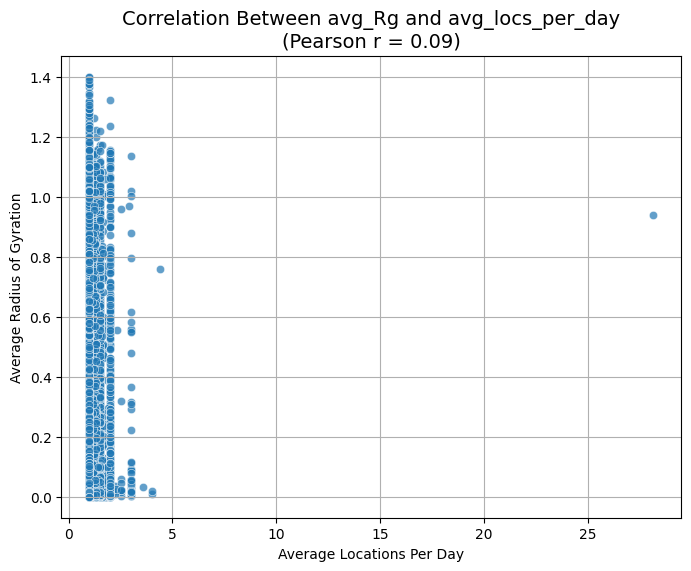

In [ ]:
#from pyspark.sql import SparkSession
#from pyspark.sql.functions import avg, corr

# Calculate User Mobility Attributes
user_mobility_df = calculate_user_mobility(cleaned_dfu)

# Calculate average locations visited per day per user
avg_locs_per_day_df = user_mobility_df.groupBy("user_id").agg(
    avg("num_locations_visited").alias("avg_locs_per_day")
)

# Calculate Radius of Gyration
radius_of_gyration_df = calculate_radius_of_gyration(cleaned_dfu)

# Join DataFrames on 'user_id'
combined_df = avg_locs_per_day_df.join(radius_of_gyration_df, on="user_id")

#  Calculate Correlation
correlation = combined_df.select(corr("avg_locs_per_day", "avg_Rg").alias("correlation")).collect()[0]["correlation"]
print(f"Pearson correlation coefficient between avg_Rg and avg_locs_per_day: {correlation}")

# Visualization
# Convert to Pandas for plotting
combined_pd_df = combined_df.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot with correlation coefficient
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=combined_pd_df["avg_locs_per_day"],
    y=combined_pd_df["avg_Rg"],
    alpha=0.7
)
plt.title(f"Correlation Between avg_Rg and avg_locs_per_day\n(Pearson r = {correlation:.2f})", fontsize=14)
plt.xlabel("Average Locations Per Day")
plt.ylabel("Average Radius of Gyration")
plt.grid(True)
plt.show()


#### Interpretations:


 The weak correlation of approximately 10%. $(r ≈ 0.1)$ suggests that the number of locations an individual visits daily does not significantly influence the spatial dispersion of their movements (radius of gyration). For example, visiting more locations does not necessarily mean a person travels further distances or covers a larger area.



The clustering at low values for both variables could imply that most individuals in the sample exhibit limited mobility and low daily activity in terms of location visits and travel distances.



The outlier at 𝑥 ≈ 25 skews the interpretation slightly, as it represents an extreme case. Removing this outlier might further reduce the already weak correlation.


Behavioral Insight: The analysis suggests that individuals who visit only a few locations per day tend to stay within smaller areas (lower gyration), while individuals who visit more locations may or may not expand their spatial activity.


### TASK 4

This project faced several big data challenges, among others, Volume of the dataset "Call Detail Records (CDRs)" demanded a lot of computational resources and processing time. To address this challenge, parallel processing was employed, specifically,  through PySpark's ability to distribute data across a cluster by using its Resilleint Distributed Dataset (RDD) functionality, which is done by reading CSV files using spark.read.csv.


Another hurdle was data variety and structure. The raw CDR data was unstructured and required cleaning, transformation, and validation. This was achieved using the preprocess_cdrs_using_spark function, which converted raw data into structured Spark DataFrames. The function also handled column renaming, location binding, and data filtering, enhancing efficiency and reliability for analysis.

Optimizing performance was crucial. PySpark, a distributed computing framework, facilitated parallel computations and accelerated processing. Caching the preprocessed DataFrame (dfu.cache()) further boosted performance by storing data in memory, minimizing disk I/O.

Data quality posed a significant concern due to the public nature of the dataset, increasing the risk of contamination. To mitigate this, data cleaning steps included format validation and error handling for missing files or directories. When the level of contaminations incresed measures taken included extracting  data from a zipped archive and securing access from everyone.

In conclusion, the project successfully navigated big data challenges using strategic techniques. PySpark's parallel processing capabilities optimized performance, while data quality checks ensured reliability. This approach enabled a comprehensive and insightful analysis of the large CDR dataset.

In [ ]:
Data volume was a primary concern. Processing vast CDR records demanded computational resources and time, to overcome this issue parallel processing came in handy.